<a target="_blank" href="https://colab.research.google.com/github/Sebelino/DD2424-project/blob/main/classify_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [21]:

import os
import sys

# Detect if running in Google Colab
try:
    import google.colab
    in_colab = True
except ImportError:
    in_colab = False

print("in_colab:", in_colab)

if in_colab:
    repo_name = "DD2424-project"
    if not os.path.exists(repo_name):
        !git clone https://github.com/Sebelino/DD2424-project
    %cd DD2424-project

in_colab: True
Cloning into 'DD2424-project'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 62 (delta 27), reused 43 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (62/62), 355.62 KiB | 5.83 MiB/s, done.
Resolving deltas: 100% (27/27), done.
/content/DD2424-project/DD2424-project/DD2424-project/DD2424-project/DD2424-project/DD2424-project


In [22]:
from download_dataset import maybe_download_and_extract

maybe_download_and_extract()

images.tar.gz: 792MB [00:23, 34.0MB/s]                           


Saved to data/oxford-iiit-pet/images.tar.gz


annotations.tar.gz: 19.2MB [00:02, 9.25MB/s]                            


Saved to data/oxford-iiit-pet/annotations.tar.gz
Extracting data/oxford-iiit-pet/images.tar.gz...
Extracted to data/oxford-iiit-pet
Extracting data/oxford-iiit-pet/annotations.tar.gz...
Extracted to data/oxford-iiit-pet


In [ ]:
import os

import torch
from torchvision import models
from torchvision.models import ResNet18_Weights

weights = ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)

Original image:


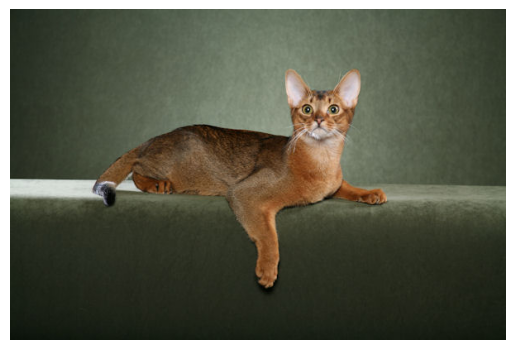

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image
from PIL import Image


def show_original_image(image):
    print("Original image:")
    plt.imshow(image)
    plt.axis("off")
    plt.show()


image_dir = "data/oxford-iiit-pet/images"
fname = "Abyssinian_1.jpg"
path = os.path.join(image_dir, fname)
image = Image.open(path).convert("RGB")

show_original_image(image)

Preprocessed:


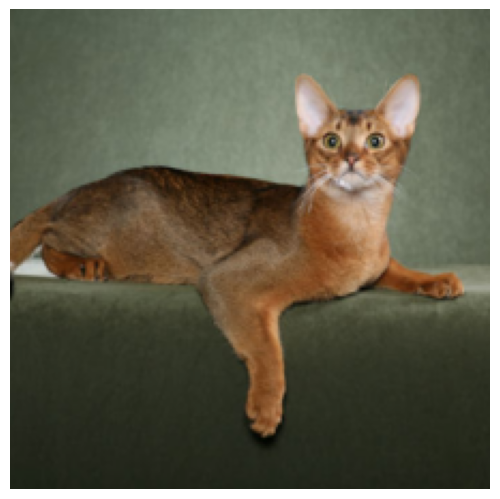

In [ ]:
def show_tensor_image(tensor, mean, std):
    """Convert normalized tensor to image and display it."""
    # Clone to avoid modifying original
    img = tensor.clone().cpu()

    # Undo normalization
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)

    # Convert from [C, H, W] to [H, W, C]
    img = img.permute(1, 2, 0).numpy()

    # Clip in case values are slightly out of range
    img = np.clip(img, 0, 1)

    print("Preprocessed:")
    plt.imshow(img)
    plt.axis("off")
    plt.gca().set_position([0, 0, 1, 1])  # Remove padding/margin


def save_tensor_image_exact(tensor, mean, std, path):
    # Undo normalization
    img = tensor.clone().cpu()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)

    # Clamp to [0, 1] to avoid artifacts
    img = torch.clamp(img, 0, 1)

    # Convert to PIL image
    pil_img = to_pil_image(img)

    # Ensure it's 224x224
    assert pil_img.size == (224, 224), f"Unexpected size: {pil_img.size}"

    # Save
    pil_img.save(path)


model.eval()  # Set model to eval mode
# ImageNet normalization and resizing
preprocess = weights.transforms()  # Includes Resize(232) → CenterCrop(224) → ToTensor() → Normalize

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

input_tensor = preprocess(image).unsqueeze(0).to(device)  # Shape: [1, 3, 224, 224]

out_path = f"preprocessed_{fname}"
show_tensor_image(input_tensor.squeeze(0), mean=preprocess.mean, std=preprocess.std)
save_tensor_image_exact(input_tensor.squeeze(0), preprocess.mean, preprocess.std, out_path)

In [ ]:
with torch.no_grad():
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    class_name = weights.meta["categories"][pred_class]

print(f"{fname:>25}: predicted as '{class_name}'")

         Abyssinian_1.jpg: predicted as 'Egyptian cat'
